In [1]:
pip install torch-fidelity wandb

In [2]:
import os
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import wandb
import time
from torch_fidelity import calculate_metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [3]:
config = {
    # dataset
    "dataset": "CIFAR-10",
    "image_size": 32,
    "channels": 3,

    # model
    "model": "KL-annealing-VAE",
    "latent_dim": 256,
    "encoder_channels": [32, 64, 128],

    # training
    "batch_size": 128,
    "epochs": 100,
    "lr": 2e-4,
    "recon_loss": "MSE",
    "beta": 0.25,
    "kl_anneal_epochs": 30,

    # evaluation
    "fid_every": 5,
    "fid_samples": 1000,
    "kid_subset_size": 300,

    # logging
    "log_images": True,
    "num_log_images": 16,
}

In [4]:
run_name = (
    "Base_VAE_final"
)

wandb.init(
    project="generative-modeling-on-cifar-10",
    name=run_name,
    config=config
)

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gioeba (gioeba-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
real_folder = "/tmp/cifar10_real"
gen_folder = "/tmp/cifar10_gen"
os.makedirs(real_folder, exist_ok=True)
os.makedirs(gen_folder, exist_ok=True)

In [6]:
real_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

if len(os.listdir(real_folder)) == 0:
    print("Saving real CIFAR-10 images...")
    for i in tqdm(range(10000)):
        img, _ = real_dataset[i]
        vutils.save_image(img, os.path.join(real_folder, f"real_{i}.png"))
else:
    print("Real images already exist, skipping.")

100%|██████████| 170M/170M [00:02<00:00, 74.9MB/s]


Saving real CIFAR-10 images...


100%|██████████| 10000/10000 [00:07<00:00, 1310.33it/s]


In [7]:
train_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

train_set = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=False,
    transform=train_transform
)

train_loader = DataLoader(
    train_set,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

In [8]:
class VAE(nn.Module):
    def __init__(self, config):
        super().__init__()
        ch = config["encoder_channels"]
        latent_dim = config["latent_dim"]

        self.encoder = nn.Sequential(
            nn.Conv2d(3, ch[0], 4, 2, 1), nn.ReLU(),
            nn.Conv2d(ch[0], ch[1], 4, 2, 1), nn.ReLU(),
            nn.Conv2d(ch[1], ch[2], 4, 2, 1), nn.ReLU()
        )

        self.fc_mu = nn.Linear(ch[2]*4*4, latent_dim)
        self.fc_logvar = nn.Linear(ch[2]*4*4, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, ch[2]*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(ch[2], ch[1], 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(ch[1], ch[0], 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(ch[0], 3, 4, 2, 1), nn.Tanh()
        )

    def encode(self, x):
        h = self.encoder(x).view(x.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z).view(-1, config["encoder_channels"][-1], 4, 4)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [9]:
def vae_loss(x_hat, x, mu, logvar):
    recon = F.mse_loss(x_hat, x, reduction="sum")
    kl = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl

In [10]:
def get_kl_weight(epoch, config):
    if epoch >= config["kl_anneal_epochs"]:
        return config["beta"]
    return config["beta"] * (epoch / config["kl_anneal_epochs"])

In [11]:
model = VAE(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

wandb.watch(model, log="gradients", log_freq=500)

fid_scores = []
kid_scores = []
epochs_list = []

for epoch in range(1, config["epochs"] + 1):
    model.train()
    epoch_start = time.time()

    total_loss = 0.0
    total_recon = 0.0
    total_kl = 0.0
    latent_mu_mean = 0.0
    latent_mu_std = 0.0
    kl_weight = get_kl_weight(epoch, config)

    for x, _ in tqdm(train_loader, desc=f"Epoch {epoch}"):
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)

        recon = F.mse_loss(x_hat, x, reduction="sum")
        kl = -0.5 * torch.sum(
            1 + logvar - mu.pow(2) - logvar.exp()
        )

        loss = recon + kl_weight * kl
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_recon += recon.item()
        total_kl += kl.item()

        latent_mu_mean += mu.mean().item()
        latent_mu_std += mu.std().item()

    avg_loss = total_loss / len(train_set)
    avg_recon = total_recon / len(train_set)
    avg_kl = total_kl / len(train_set)
    latent_mu_mean /= len(train_loader)
    latent_mu_std /= len(train_loader)

    epoch_time = time.time() - epoch_start

    wandb.log({
        "epoch": epoch,
        "train/total_loss": avg_loss,
        "train/recon_loss": avg_recon,
        "train/kl_loss": avg_kl,
        "latent/mu_mean": latent_mu_mean,
        "latent/mu_std": latent_mu_std,
        "time/epoch_sec": epoch_time,
        "train/kl_weight": kl_weight,
        "beta": config["beta"],
    }, step=epoch)

    print(
        f"Epoch {epoch} | "
        f"Loss: {avg_loss:.4f} | "
        f"Recon: {avg_recon:.4f} | "
        f"KL: {avg_kl:.4f}"
    )

    if epoch % config["fid_every"] == 0:
        model.eval()

        if os.path.exists(gen_folder):
            shutil.rmtree(gen_folder)
        os.makedirs(gen_folder, exist_ok=True)

        with torch.no_grad():
            n_samples = config["fid_samples"]
            batch_size = 64
            idx = 0

            for _ in range(n_samples // batch_size):
                z = torch.randn(
                    batch_size,
                    config["latent_dim"],
                    device=device
                )

                imgs = model.decode(z)
                imgs = (imgs + 1) / 2
                imgs = imgs.clamp(0, 1)

                for j in range(imgs.size(0)):
                    vutils.save_image(
                        imgs[j],
                        os.path.join(gen_folder, f"{idx}.png")
                    )
                    idx += 1

        metrics = calculate_metrics(
            input1=gen_folder,
            input2=real_folder,
            fid=True,
            kid=True,
            kid_subset_size=config["kid_subset_size"]
        )

        fid = metrics["frechet_inception_distance"]
        kid = metrics["kernel_inception_distance_mean"]

        fid_scores.append(fid)
        kid_scores.append(kid)
        epochs_list.append(epoch)

        wandb.log({
            "metrics/FID": fid,
            "metrics/KID": kid,
        }, step=epoch)

        if config["log_images"]:
            with torch.no_grad():
                z = torch.randn(
                    config["num_log_images"],
                    config["latent_dim"],
                    device=device
                )
                samples = model.decode(z)
                samples = (samples + 1) / 2
                samples = samples.clamp(0, 1)

            grid = vutils.make_grid(samples, nrow=4)
            wandb.log({
                "samples": wandb.Image(
                    grid.permute(1, 2, 0).cpu().numpy(),
                    caption=f"Epoch {epoch}"
                )
            }, step=epoch)

        print(
            f"Epoch {epoch} | "
            f"FID: {fid:.2f} | "
            f"KID: {kid:.5f}"
        )

Epoch 1: 100%|██████████| 391/391 [00:08<00:00, 46.74it/s]


Epoch 1 | Loss: 316.5399 | Recon: 312.4650 | KL: 488.9898


Epoch 2: 100%|██████████| 391/391 [00:06<00:00, 57.58it/s]


Epoch 2 | Loss: 155.2583 | Recon: 146.9308 | KL: 499.6457


Epoch 3: 100%|██████████| 391/391 [00:06<00:00, 59.47it/s]


Epoch 3 | Loss: 131.8415 | Recon: 120.4369 | KL: 456.1867


Epoch 4: 100%|██████████| 391/391 [00:06<00:00, 58.81it/s]


Epoch 4 | Loss: 119.4933 | Recon: 105.0685 | KL: 432.7437


Epoch 5: 100%|██████████| 391/391 [00:06<00:00, 61.35it/s]


Epoch 5 | Loss: 111.0630 | Recon: 93.8433 | KL: 413.2735


Creating feature extractor "inception-v3-compat" with features ['2048']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 321MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
/usr/local/lib/python3.12/dist-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples
Extracting features from input2
Looking for samples non-recursivel

Epoch 5 | FID: 279.81 | KID: 0.29288


Epoch 6: 100%|██████████| 391/391 [00:06<00:00, 63.01it/s]


Epoch 6 | Loss: 106.3037 | Recon: 86.5624 | KL: 394.8257


Epoch 7: 100%|██████████| 391/391 [00:06<00:00, 61.44it/s]


Epoch 7 | Loss: 103.4645 | Recon: 81.5032 | KL: 376.4785


Epoch 8: 100%|██████████| 391/391 [00:06<00:00, 59.86it/s]


Epoch 8 | Loss: 101.6896 | Recon: 77.8313 | KL: 357.8746


Epoch 9: 100%|██████████| 391/391 [00:06<00:00, 60.87it/s]


Epoch 9 | Loss: 100.6051 | Recon: 75.1211 | KL: 339.7866


Epoch 10: 100%|██████████| 391/391 [00:06<00:00, 57.18it/s]


Epoch 10 | Loss: 99.8859 | Recon: 72.9868 | KL: 322.7899


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 187.9505218858015
Kernel Inception Distance: 0.1659690284729004 ± 0.0037873633258455096


Epoch 10 | FID: 187.95 | KID: 0.16597


Epoch 11: 100%|██████████| 391/391 [00:06<00:00, 61.98it/s]


Epoch 11 | Loss: 99.2661 | Recon: 71.0861 | KL: 307.4179


Epoch 12: 100%|██████████| 391/391 [00:06<00:00, 59.43it/s]


Epoch 12 | Loss: 98.9570 | Recon: 69.5947 | KL: 293.6233


Epoch 13: 100%|██████████| 391/391 [00:06<00:00, 62.16it/s]


Epoch 13 | Loss: 98.9445 | Recon: 68.4753 | KL: 281.2545


Epoch 14: 100%|██████████| 391/391 [00:06<00:00, 61.92it/s]


Epoch 14 | Loss: 99.0776 | Recon: 67.5551 | KL: 270.1926


Epoch 15: 100%|██████████| 391/391 [00:06<00:00, 59.48it/s]


Epoch 15 | Loss: 99.3905 | Recon: 66.8898 | KL: 260.0062


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 165.02541952467251
Kernel Inception Distance: 0.13843424320220948 ± 0.0030257261081750976


Epoch 15 | FID: 165.03 | KID: 0.13843


Epoch 16: 100%|██████████| 391/391 [00:06<00:00, 62.53it/s]


Epoch 16 | Loss: 99.7046 | Recon: 66.2603 | KL: 250.8320


Epoch 17: 100%|██████████| 391/391 [00:06<00:00, 61.16it/s]


Epoch 17 | Loss: 100.2434 | Recon: 65.8620 | KL: 242.6928


Epoch 18: 100%|██████████| 391/391 [00:06<00:00, 60.76it/s]


Epoch 18 | Loss: 100.7980 | Recon: 65.4862 | KL: 235.4122


Epoch 19: 100%|██████████| 391/391 [00:06<00:00, 60.87it/s]


Epoch 19 | Loss: 101.5025 | Recon: 65.2718 | KL: 228.8259


Epoch 20: 100%|██████████| 391/391 [00:06<00:00, 62.44it/s]


Epoch 20 | Loss: 102.3275 | Recon: 65.2045 | KL: 222.7382


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 151.9956257560101
Kernel Inception Distance: 0.12632262706756592 ± 0.0029938748487295624


Epoch 20 | FID: 152.00 | KID: 0.12632


Epoch 21: 100%|██████████| 391/391 [00:06<00:00, 64.51it/s]


Epoch 21 | Loss: 103.1235 | Recon: 65.1133 | KL: 217.2008


Epoch 22: 100%|██████████| 391/391 [00:06<00:00, 61.55it/s]


Epoch 22 | Loss: 104.0662 | Recon: 65.1998 | KL: 211.9989


Epoch 23: 100%|██████████| 391/391 [00:06<00:00, 61.13it/s]


Epoch 23 | Loss: 104.9687 | Recon: 65.2582 | KL: 207.1853


Epoch 24: 100%|██████████| 391/391 [00:06<00:00, 62.33it/s]


Epoch 24 | Loss: 106.0873 | Recon: 65.5652 | KL: 202.6104


Epoch 25: 100%|██████████| 391/391 [00:06<00:00, 63.14it/s]


Epoch 25 | Loss: 106.9940 | Recon: 65.7377 | KL: 198.0299


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 141.18830668853556
Kernel Inception Distance: 0.1181189203262329 ± 0.0034744116617194563


Epoch 25 | FID: 141.19 | KID: 0.11812


Epoch 26: 100%|██████████| 391/391 [00:06<00:00, 58.92it/s]


Epoch 26 | Loss: 108.0781 | Recon: 66.0632 | KL: 193.9149


Epoch 27: 100%|██████████| 391/391 [00:06<00:00, 63.11it/s]


Epoch 27 | Loss: 109.1486 | Recon: 66.4125 | KL: 189.9383


Epoch 28: 100%|██████████| 391/391 [00:06<00:00, 61.08it/s]


Epoch 28 | Loss: 110.1975 | Recon: 66.7465 | KL: 186.2187


Epoch 29: 100%|██████████| 391/391 [00:06<00:00, 63.18it/s]


Epoch 29 | Loss: 111.3039 | Recon: 67.1883 | KL: 182.5475


Epoch 30: 100%|██████████| 391/391 [00:06<00:00, 57.17it/s]


Epoch 30 | Loss: 112.3562 | Recon: 67.5914 | KL: 179.0594


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 136.3050722209261
Kernel Inception Distance: 0.11912010669708252 ± 0.004267193173623204


Epoch 30 | FID: 136.31 | KID: 0.11912


Epoch 31: 100%|██████████| 391/391 [00:06<00:00, 58.90it/s]


Epoch 31 | Loss: 111.8622 | Recon: 67.2816 | KL: 178.3224


Epoch 32: 100%|██████████| 391/391 [00:06<00:00, 60.66it/s]


Epoch 32 | Loss: 111.4898 | Recon: 67.1163 | KL: 177.4940


Epoch 33: 100%|██████████| 391/391 [00:06<00:00, 58.50it/s]


Epoch 33 | Loss: 111.1580 | Recon: 66.8805 | KL: 177.1100


Epoch 34: 100%|██████████| 391/391 [00:06<00:00, 59.35it/s]


Epoch 34 | Loss: 110.8173 | Recon: 66.6826 | KL: 176.5388


Epoch 35: 100%|██████████| 391/391 [00:06<00:00, 60.75it/s]


Epoch 35 | Loss: 110.5049 | Recon: 66.4657 | KL: 176.1568


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 137.3527674245928
Kernel Inception Distance: 0.12676720142364503 ± 0.004054075073218977


Epoch 35 | FID: 137.35 | KID: 0.12677


Epoch 36: 100%|██████████| 391/391 [00:06<00:00, 58.69it/s]


Epoch 36 | Loss: 110.1931 | Recon: 66.2306 | KL: 175.8501


Epoch 37: 100%|██████████| 391/391 [00:06<00:00, 59.19it/s]


Epoch 37 | Loss: 109.8771 | Recon: 66.0209 | KL: 175.4248


Epoch 38: 100%|██████████| 391/391 [00:06<00:00, 60.02it/s]


Epoch 38 | Loss: 109.5990 | Recon: 65.8107 | KL: 175.1532


Epoch 39: 100%|██████████| 391/391 [00:06<00:00, 63.91it/s]


Epoch 39 | Loss: 109.3916 | Recon: 65.6864 | KL: 174.8209


Epoch 40: 100%|██████████| 391/391 [00:06<00:00, 58.97it/s]


Epoch 40 | Loss: 109.0866 | Recon: 65.4292 | KL: 174.6296


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 136.26097794759983
Kernel Inception Distance: 0.12629504680633544 ± 0.004336705298371405


Epoch 40 | FID: 136.26 | KID: 0.12630


Epoch 41: 100%|██████████| 391/391 [00:06<00:00, 59.39it/s]


Epoch 41 | Loss: 108.8776 | Recon: 65.2933 | KL: 174.3376


Epoch 42: 100%|██████████| 391/391 [00:06<00:00, 58.78it/s]


Epoch 42 | Loss: 108.6396 | Recon: 65.1001 | KL: 174.1577


Epoch 43: 100%|██████████| 391/391 [00:06<00:00, 59.14it/s]


Epoch 43 | Loss: 108.4994 | Recon: 64.9927 | KL: 174.0267


Epoch 44: 100%|██████████| 391/391 [00:06<00:00, 60.45it/s]


Epoch 44 | Loss: 108.2079 | Recon: 64.7378 | KL: 173.8807


Epoch 45: 100%|██████████| 391/391 [00:06<00:00, 62.06it/s]


Epoch 45 | Loss: 108.0750 | Recon: 64.6508 | KL: 173.6970


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 136.50433078373618
Kernel Inception Distance: 0.1300271511077881 ± 0.00520161367846087


Epoch 45 | FID: 136.50 | KID: 0.13003


Epoch 46: 100%|██████████| 391/391 [00:06<00:00, 60.60it/s]


Epoch 46 | Loss: 107.8804 | Recon: 64.4990 | KL: 173.5258


Epoch 47: 100%|██████████| 391/391 [00:06<00:00, 61.61it/s]


Epoch 47 | Loss: 107.7119 | Recon: 64.3567 | KL: 173.4206


Epoch 48: 100%|██████████| 391/391 [00:06<00:00, 59.53it/s]


Epoch 48 | Loss: 107.6186 | Recon: 64.2769 | KL: 173.3668


Epoch 49: 100%|██████████| 391/391 [00:06<00:00, 59.11it/s]


Epoch 49 | Loss: 107.4314 | Recon: 64.1463 | KL: 173.1402


Epoch 50: 100%|██████████| 391/391 [00:06<00:00, 61.56it/s]


Epoch 50 | Loss: 107.1983 | Recon: 63.9184 | KL: 173.1197


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 136.85173728591104
Kernel Inception Distance: 0.13028141498565673 ± 0.004683066797079535


Epoch 50 | FID: 136.85 | KID: 0.13028


Epoch 51: 100%|██████████| 391/391 [00:06<00:00, 58.45it/s]


Epoch 51 | Loss: 107.0980 | Recon: 63.8642 | KL: 172.9354


Epoch 52: 100%|██████████| 391/391 [00:06<00:00, 56.45it/s]


Epoch 52 | Loss: 106.9940 | Recon: 63.7624 | KL: 172.9266


Epoch 53: 100%|██████████| 391/391 [00:06<00:00, 60.69it/s]


Epoch 53 | Loss: 106.8191 | Recon: 63.6105 | KL: 172.8341


Epoch 54: 100%|██████████| 391/391 [00:06<00:00, 62.22it/s]


Epoch 54 | Loss: 106.7075 | Recon: 63.4983 | KL: 172.8368


Epoch 55: 100%|██████████| 391/391 [00:06<00:00, 59.31it/s]


Epoch 55 | Loss: 106.6029 | Recon: 63.4325 | KL: 172.6815


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 138.8739972756773
Kernel Inception Distance: 0.13604408502578735 ± 0.004916922823813468


Epoch 55 | FID: 138.87 | KID: 0.13604


Epoch 56: 100%|██████████| 391/391 [00:06<00:00, 59.37it/s]


Epoch 56 | Loss: 106.4399 | Recon: 63.2839 | KL: 172.6238


Epoch 57: 100%|██████████| 391/391 [00:06<00:00, 60.05it/s]


Epoch 57 | Loss: 106.3262 | Recon: 63.1830 | KL: 172.5726


Epoch 58: 100%|██████████| 391/391 [00:06<00:00, 61.24it/s]


Epoch 58 | Loss: 106.2162 | Recon: 63.0643 | KL: 172.6077


Epoch 59: 100%|██████████| 391/391 [00:06<00:00, 61.85it/s]


Epoch 59 | Loss: 106.1252 | Recon: 62.9811 | KL: 172.5764


Epoch 60: 100%|██████████| 391/391 [00:06<00:00, 60.83it/s]


Epoch 60 | Loss: 106.0443 | Recon: 62.9129 | KL: 172.5258


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 139.79429572941143
Kernel Inception Distance: 0.13764720916748047 ± 0.005195022811236064


Epoch 60 | FID: 139.79 | KID: 0.13765


Epoch 61: 100%|██████████| 391/391 [00:06<00:00, 58.66it/s]


Epoch 61 | Loss: 105.8684 | Recon: 62.7508 | KL: 172.4702


Epoch 62: 100%|██████████| 391/391 [00:06<00:00, 58.43it/s]


Epoch 62 | Loss: 105.7884 | Recon: 62.6977 | KL: 172.3628


Epoch 63: 100%|██████████| 391/391 [00:06<00:00, 63.31it/s]


Epoch 63 | Loss: 105.6570 | Recon: 62.5938 | KL: 172.2526


Epoch 64: 100%|██████████| 391/391 [00:06<00:00, 61.68it/s]


Epoch 64 | Loss: 105.5938 | Recon: 62.5226 | KL: 172.2848


Epoch 65: 100%|██████████| 391/391 [00:06<00:00, 59.02it/s]


Epoch 65 | Loss: 105.5421 | Recon: 62.4767 | KL: 172.2614


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 140.97769866875433
Kernel Inception Distance: 0.13939602851867675 ± 0.005151830858998055


Epoch 65 | FID: 140.98 | KID: 0.13940


Epoch 66: 100%|██████████| 391/391 [00:06<00:00, 61.34it/s]


Epoch 66 | Loss: 105.4400 | Recon: 62.3517 | KL: 172.3531


Epoch 67: 100%|██████████| 391/391 [00:06<00:00, 61.82it/s]


Epoch 67 | Loss: 105.2890 | Recon: 62.2200 | KL: 172.2760


Epoch 68: 100%|██████████| 391/391 [00:06<00:00, 60.83it/s]


Epoch 68 | Loss: 105.2259 | Recon: 62.1758 | KL: 172.2001


Epoch 69: 100%|██████████| 391/391 [00:06<00:00, 62.85it/s]


Epoch 69 | Loss: 105.1290 | Recon: 62.0776 | KL: 172.2054


Epoch 70: 100%|██████████| 391/391 [00:06<00:00, 59.71it/s]


Epoch 70 | Loss: 105.0885 | Recon: 62.0454 | KL: 172.1722


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 140.95589707620763
Kernel Inception Distance: 0.14076460838317872 ± 0.005452443475514437


Epoch 70 | FID: 140.96 | KID: 0.14076


Epoch 71: 100%|██████████| 391/391 [00:06<00:00, 60.10it/s]


Epoch 71 | Loss: 105.0418 | Recon: 61.9928 | KL: 172.1960


Epoch 72: 100%|██████████| 391/391 [00:06<00:00, 61.63it/s]


Epoch 72 | Loss: 104.8952 | Recon: 61.8481 | KL: 172.1882


Epoch 73: 100%|██████████| 391/391 [00:06<00:00, 60.88it/s]


Epoch 73 | Loss: 104.8659 | Recon: 61.8271 | KL: 172.1552


Epoch 74: 100%|██████████| 391/391 [00:06<00:00, 61.39it/s]


Epoch 74 | Loss: 104.7362 | Recon: 61.7151 | KL: 172.0844


Epoch 75: 100%|██████████| 391/391 [00:06<00:00, 60.84it/s]


Epoch 75 | Loss: 104.6803 | Recon: 61.6220 | KL: 172.2333


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 138.6688223136661
Kernel Inception Distance: 0.13536386489868163 ± 0.005624974821787406


Epoch 75 | FID: 138.67 | KID: 0.13536


Epoch 76: 100%|██████████| 391/391 [00:06<00:00, 63.24it/s]


Epoch 76 | Loss: 104.5998 | Recon: 61.5517 | KL: 172.1922


Epoch 77: 100%|██████████| 391/391 [00:06<00:00, 60.57it/s]


Epoch 77 | Loss: 104.5788 | Recon: 61.5485 | KL: 172.1212


Epoch 78: 100%|██████████| 391/391 [00:06<00:00, 60.52it/s]


Epoch 78 | Loss: 104.5040 | Recon: 61.4421 | KL: 172.2475


Epoch 79: 100%|██████████| 391/391 [00:06<00:00, 59.10it/s]


Epoch 79 | Loss: 104.4386 | Recon: 61.3721 | KL: 172.2659


Epoch 80: 100%|██████████| 391/391 [00:06<00:00, 60.37it/s]


Epoch 80 | Loss: 104.3773 | Recon: 61.2967 | KL: 172.3224


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 141.14571466440742
Kernel Inception Distance: 0.14141890048980713 ± 0.005735777931730314


Epoch 80 | FID: 141.15 | KID: 0.14142


Epoch 81: 100%|██████████| 391/391 [00:06<00:00, 58.57it/s]


Epoch 81 | Loss: 104.2882 | Recon: 61.2385 | KL: 172.1988


Epoch 82: 100%|██████████| 391/391 [00:06<00:00, 60.71it/s]


Epoch 82 | Loss: 104.2856 | Recon: 61.2151 | KL: 172.2818


Epoch 83: 100%|██████████| 391/391 [00:06<00:00, 59.66it/s]


Epoch 83 | Loss: 104.1971 | Recon: 61.1165 | KL: 172.3224


Epoch 84: 100%|██████████| 391/391 [00:06<00:00, 59.72it/s]


Epoch 84 | Loss: 104.1540 | Recon: 61.0860 | KL: 172.2722


Epoch 85: 100%|██████████| 391/391 [00:06<00:00, 58.92it/s]


Epoch 85 | Loss: 104.0579 | Recon: 60.9926 | KL: 172.2613


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 140.26092535722216
Kernel Inception Distance: 0.14062102556228637 ± 0.005879981312537055


Epoch 85 | FID: 140.26 | KID: 0.14062


Epoch 86: 100%|██████████| 391/391 [00:06<00:00, 60.37it/s]


Epoch 86 | Loss: 104.0057 | Recon: 60.9148 | KL: 172.3633


Epoch 87: 100%|██████████| 391/391 [00:06<00:00, 62.16it/s]


Epoch 87 | Loss: 103.9378 | Recon: 60.8438 | KL: 172.3760


Epoch 88: 100%|██████████| 391/391 [00:06<00:00, 62.54it/s]


Epoch 88 | Loss: 103.9318 | Recon: 60.8231 | KL: 172.4349


Epoch 89: 100%|██████████| 391/391 [00:06<00:00, 58.17it/s]


Epoch 89 | Loss: 103.8411 | Recon: 60.7407 | KL: 172.4015


Epoch 90: 100%|██████████| 391/391 [00:06<00:00, 61.28it/s]


Epoch 90 | Loss: 103.8127 | Recon: 60.7359 | KL: 172.3071


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 140.63967698223018
Kernel Inception Distance: 0.14193066120147704 ± 0.005014430791684745


Epoch 90 | FID: 140.64 | KID: 0.14193


Epoch 91: 100%|██████████| 391/391 [00:06<00:00, 60.79it/s]


Epoch 91 | Loss: 103.7391 | Recon: 60.6520 | KL: 172.3486


Epoch 92: 100%|██████████| 391/391 [00:06<00:00, 60.59it/s]


Epoch 92 | Loss: 103.6541 | Recon: 60.5686 | KL: 172.3421


Epoch 93: 100%|██████████| 391/391 [00:06<00:00, 58.47it/s]


Epoch 93 | Loss: 103.6754 | Recon: 60.5891 | KL: 172.3451


Epoch 94: 100%|██████████| 391/391 [00:06<00:00, 60.03it/s]


Epoch 94 | Loss: 103.6642 | Recon: 60.5252 | KL: 172.5561


Epoch 95: 100%|██████████| 391/391 [00:06<00:00, 58.54it/s]


Epoch 95 | Loss: 103.5681 | Recon: 60.4560 | KL: 172.4484


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 140.70623072342505
Kernel Inception Distance: 0.14015797138214112 ± 0.005807904424860985


Epoch 95 | FID: 140.71 | KID: 0.14016


Epoch 96: 100%|██████████| 391/391 [00:06<00:00, 60.92it/s]


Epoch 96 | Loss: 103.4846 | Recon: 60.3623 | KL: 172.4892


Epoch 97: 100%|██████████| 391/391 [00:06<00:00, 61.44it/s]


Epoch 97 | Loss: 103.4886 | Recon: 60.3508 | KL: 172.5510


Epoch 98: 100%|██████████| 391/391 [00:06<00:00, 59.23it/s]


Epoch 98 | Loss: 103.4483 | Recon: 60.3308 | KL: 172.4699


Epoch 99: 100%|██████████| 391/391 [00:06<00:00, 61.19it/s]


Epoch 99 | Loss: 103.3649 | Recon: 60.2249 | KL: 172.5601


Epoch 100: 100%|██████████| 391/391 [00:06<00:00, 56.75it/s]


Epoch 100 | Loss: 103.4071 | Recon: 60.2277 | KL: 172.7175


Creating feature extractor "inception-v3-compat" with features ['2048']
Extracting features from input1
Looking for samples non-recursivelty in "/tmp/cifar10_gen" with extensions png,jpg,jpeg
Found 960 samples
Processing samples
Extracting features from input2
Looking for samples non-recursivelty in "/tmp/cifar10_real" with extensions png,jpg,jpeg
Found 10000 samples
Processing samples
Frechet Inception Distance: 137.7129893042479
                                                                                 

Epoch 100 | FID: 137.71 | KID: 0.13549


Kernel Inception Distance: 0.13549447298049927 ± 0.005676960827976774


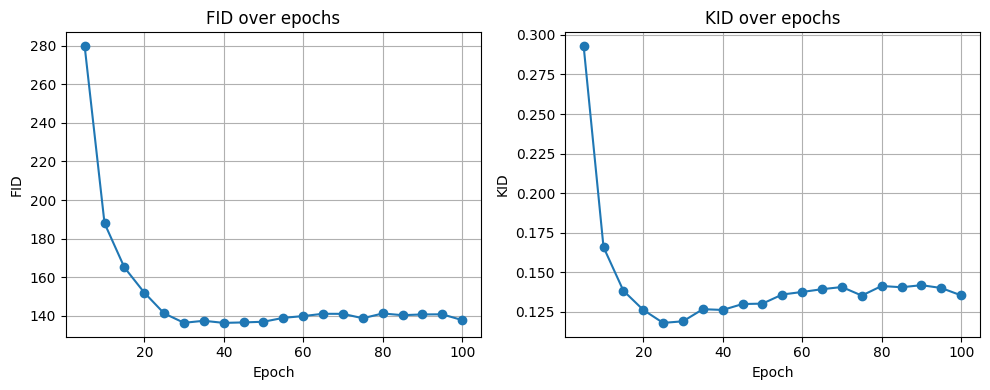

<Figure size 640x480 with 0 Axes>

In [12]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_list, fid_scores, marker="o")
plt.title("FID over epochs")
plt.xlabel("Epoch")
plt.ylabel("FID")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_list, kid_scores, marker="o")
plt.title("KID over epochs")
plt.xlabel("Epoch")
plt.ylabel("KID")
plt.grid(True)

plt.tight_layout()
plt.show()

wandb.log({
    "FID_KID_curves": wandb.Image(plt.gcf())
})

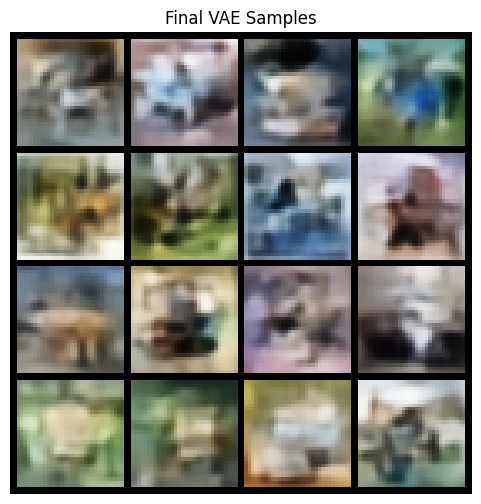

beta,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
latent/mu_mean,▁▃▃▃▄▆▇▇▇▇██████████████████████████████
latent/mu_std,█▇▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/FID,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
metrics/KID,█▃▂▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂
time/epoch_sec,▆▂▇▃▃▅▁▂▆▂▆▆▆▅▆▃▄▅▆█▅▅▃▆▄▅▅▃▄▃▄▄▄▆▄▄▅▆▄█
train/kl_loss,█▇▆▆▆▄▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/kl_weight,▁▃▄▄▅▆▆▆▇▇██████████████████████████████
train/recon_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+1,...


In [13]:
model.eval()
with torch.no_grad():
    z = torch.randn(16, config["latent_dim"]).to(device)
    samples = model.decode(z)
    samples = (samples + 1) / 2
    samples = samples.clamp(0, 1)

grid = vutils.make_grid(samples, nrow=4)
plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title("Final VAE Samples")
plt.show()

wandb.log({
    "final_samples": wandb.Image(
        grid.permute(1, 2, 0).cpu().numpy(),
        caption="Final VAE Samples"
    )
})

wandb.finish()